<a href="https://colab.research.google.com/github/DiegoCorona/TensorFlow2-for-Deep-Learning/blob/main/Week4_Tensorflow_for_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install --upgrade tensorflow ### v 2.5
#!pip install 'h5py==2.10.0' --force-reinstall

In [3]:
#!pip install --ignore-installed --upgrade tensorflow==2.0


In [4]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [5]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

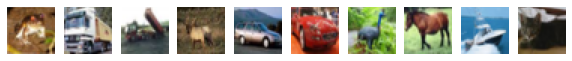

In [6]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [7]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [8]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [9]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

In [10]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.112


#### Train model with checkpoints

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path, frecuency = 'epoch', save_weights_only= True, verbose =1)

In [13]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch
model.fit(x_train, y_train, epochs=3, callbacks= [checkpoint])


Train on 10000 samples
Epoch 1/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.9784 - accuracy: 0.2696
Epoch 00001: saving model to model_checkpoints/checkpoint
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.9779 - accuracy: 0.2696
Epoch 2/3
 9952/10000 [============================>.] - ETA: 0s - loss: 1.7052 - accuracy: 0.3861
Epoch 00002: saving model to model_checkpoints/checkpoint
10000/10000 [==============================] - 12s 1ms/sample - loss: 1.7043 - accuracy: 0.3866
Epoch 3/3
 9952/10000 [============================>.] - ETA: 0s - loss: 1.5878 - accuracy: 0.4331
Epoch 00003: saving model to model_checkpoints/checkpoint
10000/10000 [==============================] - 12s 1ms/sample - loss: 1.5863 - accuracy: 0.4340


In [14]:
# Have a look at what the checkpoint creates
! ls -1h model_checkpoints

#checkpoint.data-00000-of-00001 guarda los pesos reales, los demas son metadata

checkpoint
checkpoint.data-00000-of-00001
checkpoint.index


In [15]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

accuracy: 0.440


#### Create new model, load weights

In [16]:
# Create a new instance of the (initialised) model, accuracy around 10% again

new_model = get_new_model()
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.108


In [17]:
# Load weights -- accuracy is the same as the trained model

new_model.load_weights(checkpoint_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.440


#### Clear directory

In [18]:
! rm -r model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [20]:
# Create Tensorflow checkpoint object with epoch and batch details
checkpoint_500_path = 'model_checkpoints_500/checkpoint_{epoch:02d}_{batch:04d}'
checkpoint_500 = ModelCheckpoint(filepath = checkpoint_500_path,
                                  save_weights_only = True, 
                                  save_freq = 500, 
                                  Verbose = 1)

In [21]:
# Create and fit model with checkpoint

model_500 = get_new_model()
model_500.fit(x_train, y_train, epochs = 3, validation_data = (x_test, y_test),
               batch_size = 10, callbacks = [checkpoint_500]) ### TEnsorflow v 2.4 don´t run with this, just v 2.0

Train on 10000 samples, validate on 1000 samples
Epoch 1/3
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.8665 - accuracy: 0.3184 - val_loss: 1.5849 - val_accuracy: 0.4600
Epoch 2/3
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.4879 - accuracy: 0.4653 - val_loss: 1.4064 - val_accuracy: 0.4930
Epoch 3/3
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.3338 - accuracy: 0.5223 - val_loss: 1.3557 - val_accuracy: 0.5240


In [22]:
# Have a look at what the checkpoint creates
! ls -1h model_checkpoints_500

checkpoint
checkpoint_01_0049.data-00000-of-00001
checkpoint_01_0049.index
checkpoint_01_0099.data-00000-of-00001
checkpoint_01_0099.index
checkpoint_01_0149.data-00000-of-00001
checkpoint_01_0149.index
checkpoint_01_0199.data-00000-of-00001
checkpoint_01_0199.index
checkpoint_01_0249.data-00000-of-00001
checkpoint_01_0249.index
checkpoint_01_0299.data-00000-of-00001
checkpoint_01_0299.index
checkpoint_01_0349.data-00000-of-00001
checkpoint_01_0349.index
checkpoint_01_0399.data-00000-of-00001
checkpoint_01_0399.index
checkpoint_01_0449.data-00000-of-00001
checkpoint_01_0449.index
checkpoint_01_0499.data-00000-of-00001
checkpoint_01_0499.index
checkpoint_01_0549.data-00000-of-00001
checkpoint_01_0549.index
checkpoint_01_0599.data-00000-of-00001
checkpoint_01_0599.index
checkpoint_01_0649.data-00000-of-00001
checkpoint_01_0649.index
checkpoint_01_0699.data-00000-of-00001
checkpoint_01_0699.index
checkpoint_01_0749.data-00000-of-00001
checkpoint_01_0749.index
checkpoint_01_0799.data-00000

#### Work with model saving criteria

In [23]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [24]:
# Create a new instance of untrained model
model_2 = get_new_model()

In [25]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path = 'model_checkpoint_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath= checkpoint_best_path,
                                  save_weights_only = True,
                                  save_freq = 'epoch',
                                  monitor = 'val_accuracy',
                                  save_best = True,
                                  verbose = 1)

In [26]:
# Fit the model and save only the weights with the highest validation accuracy
history = model_2.fit(x_train, y_train, epochs = 50, validation_data = (x_test, y_test), 
                      batch_size = 10, callbacks = [checkpoint_best], verbose = 0)



Epoch 00001: saving model to model_checkpoint_best/checkpoint

Epoch 00002: saving model to model_checkpoint_best/checkpoint

Epoch 00003: saving model to model_checkpoint_best/checkpoint

Epoch 00004: saving model to model_checkpoint_best/checkpoint

Epoch 00005: saving model to model_checkpoint_best/checkpoint

Epoch 00006: saving model to model_checkpoint_best/checkpoint

Epoch 00007: saving model to model_checkpoint_best/checkpoint

Epoch 00008: saving model to model_checkpoint_best/checkpoint

Epoch 00009: saving model to model_checkpoint_best/checkpoint

Epoch 00010: saving model to model_checkpoint_best/checkpoint

Epoch 00011: saving model to model_checkpoint_best/checkpoint

Epoch 00012: saving model to model_checkpoint_best/checkpoint

Epoch 00013: saving model to model_checkpoint_best/checkpoint

Epoch 00014: saving model to model_checkpoint_best/checkpoint

Epoch 00015: saving model to model_checkpoint_best/checkpoint

Epoch 00016: saving model to model_checkpoint_best/che

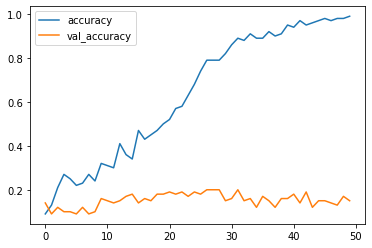

In [27]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [28]:
# Inspect the checkpoint directory

! ls -1h model_checkpoint_best

checkpoint
checkpoint.data-00000-of-00001
checkpoint.index


In [29]:
# Create a new model with the saved weights

check_model = get_new_model()
check_model.load_weights(checkpoint_best_path)
get_test_accuracy(check_model,x_test, y_test)

accuracy: 0.150


#### Clear directory

In [30]:
! rm -r model_checkpoints_500 model_checkpoint_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [46]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoint/checkpoints'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_weights_only = False,
                             frecuency = 'epoch',
                             verbose = 1)

In [47]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x_train, y_train, epochs= 3, callbacks=[checkpoint])


Train on 100 samples
Epoch 1/3
 96/100 [===========================>..] - ETA: 0s - loss: 2.3224 - accuracy: 0.1042
Epoch 00001: saving model to model_checkpoint/checkpoints
INFO:tensorflow:Assets written to: model_checkpoint/checkpoints/assets
100/100 [==============================] - 1s 15ms/sample - loss: 2.3204 - accuracy: 0.1100
Epoch 2/3
 96/100 [===========================>..] - ETA: 0s - loss: 2.2894 - accuracy: 0.1458
Epoch 00002: saving model to model_checkpoint/checkpoints
INFO:tensorflow:Assets written to: model_checkpoint/checkpoints/assets
100/100 [==============================] - 1s 8ms/sample - loss: 2.2906 - accuracy: 0.1400
Epoch 3/3
 96/100 [===========================>..] - ETA: 0s - loss: 2.2743 - accuracy: 0.1771
Epoch 00003: saving model to model_checkpoint/checkpoints
INFO:tensorflow:Assets written to: model_checkpoint/checkpoints/assets
100/100 [==============================] - 1s 8ms/sample - loss: 2.2746 - accuracy: 0.1700


#### Inspect what the checkpoint has created

In [34]:
# Have a look at what the checkpoint creates
! ls -lh model_checkpoint/checkpoints

total 128K
drwxr-xr-x 2 root root 4.0K May 26 22:28 assets
-rw-r--r-- 1 root root 119K May 26 22:28 saved_model.pb
drwxr-xr-x 2 root root 4.0K May 26 22:28 variables


In [35]:
# Enter variables directory
! ls -lh model_checkpoint/checkpoints/variables/

total 184K
-rw-r--r-- 1 root root 177K May 26 22:28 variables.data-00000-of-00001
-rw-r--r-- 1 root root 2.1K May 26 22:28 variables.index


In [36]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)


accuracy: 0.060


#### Create new model from scratch

In [37]:
# Delete model
del model

In [38]:
from tensorflow.keras.models import load_model

In [39]:
# Reload model from scratch

reloaded_model = load_model(checkpoint_path)
get_test_accuracy(reloaded_model, x_test, y_test)

accuracy: 0.060


#### Use the .h5 format to save model

In [40]:
# Save the model in .h5 format
reloaded_model.save('my_model.h5')

In [41]:
# Inspect .h5 file
! ls -lh my_model.h5

-rw-r--r-- 1 root root 77K May 26 22:28 my_model.h5


In [42]:
# Delete model
del reloaded_model

In [43]:
# Reload model from scratch
again_reloaded_model = load_model('my_model.h5')
get_test_accuracy(again_reloaded_model, x_test, y_test)


accuracy: 0.060


#### Clear directory

In [44]:
! rm -r model_checkpoint
! rm my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model using the Keras API.

In [48]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights="imagenet") ### This line runs in v 2.10 of keras

#### Import and preprocess 3 sample images

In [49]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [50]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [52]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

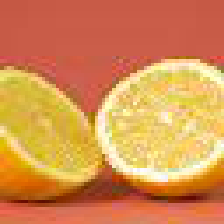

In [53]:
# Display image

lemon_img

In [54]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)


40960/35363 [==================================] - 0s 0us/step


,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.0400882
5,spotlight,0.0291972


##### Image 2: viaduct

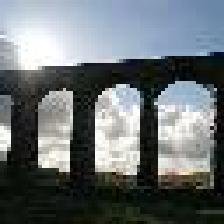

In [55]:
# Display image
viaduct_img

In [56]:
# Display top 5 predictions
get_top_5_predictions(viaduct_img)

,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110738
4,window_screen,0.0882308
5,fire_screen,0.0206753


##### Image 3: water tower

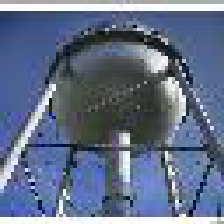

In [57]:
# Display image
water_tower_img

In [58]:
# Display top 5 predictions
get_top_5_predictions(water_tower_img)

,prediction,probability
1,solar_dish,0.384682
2,ladle,0.196178
3,planetarium,0.116683
4,strainer,0.04999
5,jigsaw_puzzle,0.0219474


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model from TensorFlow Hub.

In [59]:
import tensorflow_hub as hub

In [60]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])

#### Use MobileNet model to classify images

In [61]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [62]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("water_tower.jpg", target_size=(160, 160))

In [70]:
!wget -q -O imagenet_categories.txt --no-check-certificate "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

with open('imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [71]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

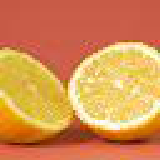

In [72]:
lemon_img

In [73]:
get_top_5_predictions(lemon_img)

,prediction
1,shower cap
2,tray
3,candle
4,brassiere
5,African chameleon


##### Image 2: viaduct

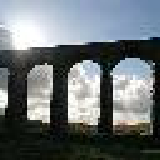

In [74]:
viaduct_img

In [75]:
get_top_5_predictions(viaduct_img)

,prediction
1,viaduct
2,pier
3,dam
4,prison
5,solar dish


##### Image 3: water tower

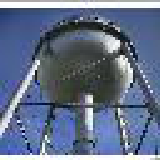

In [76]:
water_tower_img

In [77]:
get_top_5_predictions(water_tower_img)

,prediction
1,solar dish
2,water tower
3,aircraft carrier
4,jigsaw puzzle
5,oxygen mask
